<a href="https://colab.research.google.com/github/Ajay-user/ML-DL-RL-repo/blob/master/Transformers/Englsih%20to%20Malayalam%20Translation/Transformer_model_English_to_Malayalam_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
! pip install -q -U "tensorflow-text==2.8.*"

In [8]:
import os
import re
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_text as tf_text

##Import the data 🧲


In [9]:
raw = tf.data.TFRecordDataset('./eng-mal.tfrecord')
raw

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [10]:
feature_desc = {
    'english' : tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=''),
    'malayalam' : tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value='')
}

def parser(proto):
  return tf.io.parse_single_example(proto, feature_desc)

raw = raw.map(parser)

In [11]:
# reading the data

for item in raw.take(5):
  print(item['english'].numpy())
  print((item['malayalam'].numpy()).decode('utf-8'))

b'Really?'
ശരിക്കും?
b'Help me.'
എന്നെ സഹായിക്കൂ.
b'Welcome.'
സ്വാഗതം.
b'I forgot.'
ഞാന്‍ മറന്നു.
b'I am sure.'
എനിക്ക് ഉറപ്പാണ്.


In [12]:
english_text = [item['english'].numpy().decode('utf-8') for item in raw]
malayalam_text = [(item['malayalam'].numpy()).decode('utf-8') for item in raw]

In [13]:
english_text[-1], malayalam_text[-1]

("a train's left tail light", 'ഒരു ട്രെയിനിന്റെ ഇടത് ടെയിൽ ലൈറ്റ്')

In [14]:
# number of examples 
len(english_text)

32137

## Prepare the dataset 🖥

In [15]:
ds = tf.data.Dataset.from_tensor_slices((english_text, malayalam_text))

In [16]:
BATCH_SIZE = 64

In [17]:
sample_english_batch, sample_malayalam_batch = next(iter(ds.batch(BATCH_SIZE).shuffle(len(english_text))))

for eng, mal in zip(sample_english_batch[:5], sample_malayalam_batch[:5]):
  print(eng.numpy())
  print(mal.numpy().decode())

b'the carton is gold'
സ്വർണ നിറമുള്ള കാർഡ്ബോർഡ് പെട്ടി
b'glass window on building'
വർണ്ണാഭമായ സ്കാർഫ് ധരിച്ച ഒരു സ്ത്രീ
b'large tan clay pot'
വലിയ ടാൻ കളിമൺ കലം
b'the signs are neon'
അടയാളങ്ങൾ നിയോൺ ആണ്
b'green peas'
ഗ്രീൻ പീസ്


## Process the dataset ⚛

In [18]:
# standardize the text -- pass this to text-vectorizer
def normalize_lowercase_append(text):
  normalize = tf_text.normalize_utf8(text, 'NFKD')
  lowercase = tf_text.case_fold_utf8(normalize)
  text = tf.strings.join(['[START]', lowercase, '[END]'], separator=" ")
  return text

In [19]:
MAX_VOCAB_SIZE = 8000
english_text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=MAX_VOCAB_SIZE, standardize=normalize_lowercase_append)
malayalam_text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=MAX_VOCAB_SIZE, standardize=normalize_lowercase_append)

In [20]:
english_text_vectorizer.adapt(english_text)
malayalam_text_vectorizer.adapt(malayalam_text)

In [21]:
english_text_vectorizer.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'a', 'the', 'on', 'is', 'of', 'in']

In [22]:
malayalam_text_vectorizer.get_vocabulary()[:8]

['', '[UNK]', '[START]', '[END]', 'ഒരു', 'കറുത്ത', 'വെളുത്ത', 'സ്ത്രീ']

In [23]:
english_text_vectorizer.vocabulary_size()

7507

In [24]:
malayalam_text_vectorizer.vocabulary_size()

8000

In [25]:
sample_english_tokens = english_text_vectorizer(sample_english_batch)
sample_malayalam_tokens = malayalam_text_vectorizer(sample_malayalam_batch)

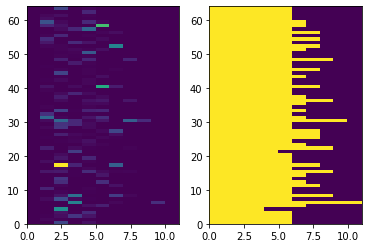

In [26]:
plt.subplot(121)
plt.pcolormesh(sample_english_tokens)
plt.subplot(122)
plt.pcolormesh(sample_english_tokens!=0)
plt.show()

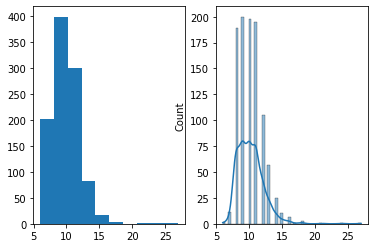

In [27]:
seq_len = []
for (en, mal) in ds.batch(BATCH_SIZE):
  en_tok = english_text_vectorizer(en)
  seq_len.append(en_tok.shape[1])
  mal_tok = malayalam_text_vectorizer(mal)
  seq_len.append(mal_tok.shape[1])

plt.subplot(121)
plt.hist(seq_len);
plt.subplot(122)
sns.histplot(seq_len, kde=True);

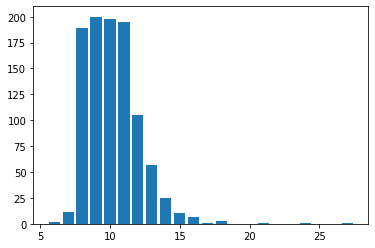

In [28]:
from collections import Counter

c = Counter(seq_len)
# print(c)
plt.bar(c.keys(), c.values());

### vocabulary analysis 🔈
  We only have short sentences in our dataset.
  Quality of model depends on the quality of the data

  Since majority of sentences are short we are capping at 16

In [29]:
# lets cap the maximum lenght at 16
MAX_TOKENS = 16

def filter_text(en, mal):
  seq_len = tf.maximum(tf.shape(en)[1], tf.shape(mal)[1])
  return seq_len < MAX_TOKENS

def get_tokens(en, mal):
  en_toks = english_text_vectorizer(en)
  mal_toks = malayalam_text_vectorizer(mal)
  return en_toks, mal_toks
  
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def process_the_dataset(ds):
  ds = ds.cache()
  ds = ds.shuffle(BUFFER_SIZE)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.map(get_tokens, num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.filter(filter_text)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds


### Token generation 🧰

In [30]:
token_ds = process_the_dataset(ds)

# lets check everything is inplace
en_token_batch, mal_token_batch = next(iter(token_ds))
print('English token batch shape',en_token_batch.shape)
print('Malayalam token batch shape',mal_token_batch.shape)

English token batch shape (64, 10)
Malayalam token batch shape (64, 9)


## Positional Encoding 📶


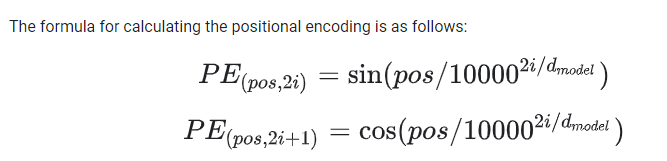

In [31]:
def get_angle(p, i, d):
  frac = 1/np.power(10000,(2*(i//2)/np.float32(d)))
  return p*frac

In [32]:
def positional_encoding(positions, dims):
  positions = np.arange(positions)[:,np.newaxis]
  i = np.arange(dims)[np.newaxis,:]
  theta = get_angle(positions, i, dims)

  theta[:,0::2] = np.sin(theta[:,0::2])
  theta[:,1::2] = np.cos(theta[:,1::2])

  pe = tf.cast(theta, dtype=tf.float32)
  return pe[tf.newaxis,:]

In [33]:
# example  pe
pe = positional_encoding(1024, 512)
pe.shape

TensorShape([1, 1024, 512])

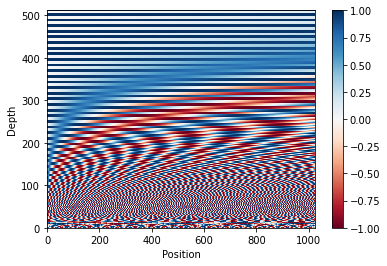

In [34]:
plt.pcolormesh(tf.transpose(pe[0]),cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Mask 😷
* padding mask
* lookahead mask

In [35]:
def create_padding_mask(seq):
  # seq -> [batch, seq]
  mask = tf.math.equal(seq,0)
  mask = tf.cast(mask,dtype=tf.float32)
  # [batch, 1, 1, seq]
  return mask[:,tf.newaxis,tf.newaxis,:] 

In [36]:
# example creating mask
print('Shape of english tokens', sample_english_tokens.shape)
sample_english_mask = create_padding_mask(sample_english_tokens)
print('Shape of english mask', sample_english_mask.shape)
sample_malayalam_mask = create_padding_mask(sample_malayalam_tokens)
print('Shape of malayalam mask', sample_malayalam_mask.shape)

Shape of english tokens (64, 11)
Shape of english mask (64, 1, 1, 11)
Shape of malayalam mask (64, 1, 1, 13)


In [37]:
def create_lookahead_mask(size):
  ones = tf.ones(shape=[size,size])
  lt =  tf.linalg.band_part(ones, -1, 0)
  return 1-lt
  

In [38]:
# let see an example of lookahead mask
size = tf.shape(sample_malayalam_tokens)[1]
sample_lookahead_mask = create_lookahead_mask(size)
print('Shape of lower triangular mask', sample_lookahead_mask.shape)

print('Shape of malayalam padding mask',sample_malayalam_mask.shape)
padding_and_lookahead = tf.maximum(sample_malayalam_mask, sample_lookahead_mask)
print('Shape of padding and lookahead mask ', padding_and_lookahead.shape)

Shape of lower triangular mask (13, 13)
Shape of malayalam padding mask (64, 1, 1, 13)
Shape of padding and lookahead mask  (64, 1, 13, 13)


## Scaled dot product attention 🧮

In [39]:
def scaled_dot_product_attention(q, k, v, mask=None):
  # dot product  -- query . key
  # [batch, query, dim].[batch, key, dim]T --> [batch, query, key]
  dot = tf.matmul(q, k, transpose_b=True)
  # scale the dot product by sqrt of dim
  dim = tf.shape(q)[-1]
  dim = tf.cast(dim, dtype=tf.float32)
  dot /= tf.math.sqrt(dim)
  # apply mask
  if mask is not None:
    dot += (mask*-1e9)
  # relative similarity score or weights --> [batch, q, k]
  # As the softmax normalization is done along the dimension for keys, 
  # the attention values decide the amount of importance given to the keys for each query.
  attention_weights = tf.nn.softmax(dot, axis=-1)
  # attention vector [batch, q, k] . [batch, v, dims] --> [batch, q, dims]
  attention_vector = tf.matmul(attention_weights,v) 
  return attention_vector, attention_weights


In [40]:
# testing the attention

sample_english_vocab_size = english_text_vectorizer.vocabulary_size()
sample_malayalam_vocab_size = malayalam_text_vectorizer.vocabulary_size()

sample_english_encoding = tf.keras.layers.Embedding(sample_english_vocab_size, 512)(sample_english_tokens)
sample_malayalam_encoding = tf.keras.layers.Embedding(sample_malayalam_vocab_size, 512)(sample_malayalam_tokens)

mask = sample_english_mask

vector = sample_english_encoding
q, k ,v = vector, vector, vector
v, w = scaled_dot_product_attention(q,k,v,mask=None)

print('Shape of English tokens',sample_english_tokens.shape)
print('Shape of English encoding',sample_english_encoding.shape)
print('Shape of attention vector',v.shape)
print('Shape of attention weights',w.shape)

Shape of English tokens (64, 11)
Shape of English encoding (64, 11, 512)
Shape of attention vector (64, 11, 512)
Shape of attention weights (64, 11, 11)


## Multi Head Attention 📡

In [41]:

class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, dims, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.dims = dims
    self.heads = num_heads
    self.depth = dims//num_heads

    # TDD -- Test Driven Development
    tf.assert_equal((dims%num_heads),0)

    # linear layers
    self.dq = tf.keras.layers.Dense(dims)
    self.dk = tf.keras.layers.Dense(dims)
    self.dv = tf.keras.layers.Dense(dims)

    self.dense = tf.keras.layers.Dense(dims)

  def split_head(self, vector):
    # [batch, seq, dims] --> [batch, seq, head, depth]
    vec = tf.reshape(vector, shape=[self.batch, -1, self.heads, self.depth])
    # [batch, seq, head, depth] --> [batch, head, seq, depth]
    vec = tf.transpose(vec, [0,2,1,3])
    return vec
    
  def combine_heads(self, vector):
    # [batch, head, seq, depth] --> [batch, seq, head, depth]
    vec = tf.transpose(vector, [0,2,1,3])
    # [batch, seq, head, depth] --> [batch, seq, dims]
    vec = tf.reshape(vec, shape=[self.batch, -1, self.dims])
    return vec

  def call(self, q, k ,v, mask):

    self.batch = tf.shape(q)[0]
    # linear layer
    dq = self.dq(q)
    dk = self.dk(k)
    dv = self.dv(v)
    # split heads
    q = self.split_head(dq)
    k = self.split_head(dk)
    v = self.split_head(dv)
    # attention
    attention_vector, attention_weights = scaled_dot_product_attention(q,k,v,mask)
    # combine heads
    attention_vector = self.combine_heads(attention_vector)
    attention_vector = self.dense(attention_vector)

    return attention_vector, attention_weights

    

In [42]:
# test multi head attention
mha = MultiHeadAttention(512, 8)
v, w = mha(q, k, v, mask)
print('Shape of attention vector',v.shape)
print('Shape of attention weights',w.shape)

Shape of attention vector (64, 11, 512)
Shape of attention weights (64, 8, 11, 11)


## FFNN ⛓

In [43]:
def FFNN(dims, dense_units):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dense_units,'relu'),
      tf.keras.layers.Dense(dims)
  ])

## Encoder Layers 🚧

In [44]:
class Encoder_Layer(tf.keras.layers.Layer):
  def __init__(self, dims, dense_units, num_heads, drop_out_rate=0.1):
    super(Encoder_Layer, self).__init__()

    self.ffnn = FFNN(dims, dense_units)

    self.mha = MultiHeadAttention(dims, num_heads)

    self.dropout_1 = tf.keras.layers.Dropout(drop_out_rate)
    self.dropout_2 = tf.keras.layers.Dropout(drop_out_rate)

    self.add_and_normalize_1 = tf.keras.layers.LayerNormalization()
    self.add_and_normalize_2 = tf.keras.layers.LayerNormalization()

  def call(self, x, mask, training):
    # multi-head-attention
    attention_vector, attention_weights = self.mha(x, x, x, mask)
    # drop-out
    d1 = self.dropout_1(attention_vector, training=training)
    # add and normalize
    out_1 = self.add_and_normalize_1(x + d1)
    # feed forward neural nets
    ffnn_out = self.ffnn(out_1)
    # drop-out
    d2 = self.dropout_2(ffnn_out, training=training)
    # add and normalize
    out_2 = self.add_and_normalize_2(out_1 + d2)

    return out_2


In [45]:
# test encoder layer
enc_layer = Encoder_Layer(512, 2048, 8, 0.1)
pe = positional_encoding(16, 512)
seq_len = sample_english_encoding.shape[1]
x = pe[:,:seq_len,:] + sample_english_encoding
enc_out = enc_layer(x, sample_english_mask, training=False)
print('Intput shape of encoder layer', x.shape)
print('Output shape of encoder layer', enc_out.shape)

Intput shape of encoder layer (64, 11, 512)
Output shape of encoder layer (64, 11, 512)


## Decoder Layer 🚧

In [46]:
class Decoder_Layer(tf.keras.layers.Layer):
  def __init__(self, dims, dense_units, num_heads, drop_out_rate=0.1):
    super(Decoder_Layer, self).__init__()
    
    # multi-head-attention
    self.mha = MultiHeadAttention(dims, num_heads)
    # masked-multi-head-attention
    self.mmha = MultiHeadAttention(dims, num_heads)
    # feed forward neural nets
    self.ffnn = FFNN(dims, dense_units)

    # drop-out-layer
    self.dropout_1 = tf.keras.layers.Dropout(drop_out_rate)
    self.dropout_2 = tf.keras.layers.Dropout(drop_out_rate)
    self.dropout_3 = tf.keras.layers.Dropout(drop_out_rate)

    # layer normalization
    self.add_and_normalize_1 = tf.keras.layers.LayerNormalization()
    self.add_and_normalize_2 = tf.keras.layers.LayerNormalization()
    self.add_and_normalize_3 = tf.keras.layers.LayerNormalization()

  def call(self, x, encoder_out, mask, training):
    # masked multi head attention
    attention_vector_1, attention_weights_1 = self.mmha(x, x, x, mask['lookahead'])
    # drop-out
    d1 = self.dropout_1(attention_vector_1, training=training)
    # add and noramlize
    out_1 = self.add_and_normalize_1(x + d1)

    # multi head attention
    attention_vector_2, attention_weights_2 = self.mha(out_1, encoder_out, encoder_out, mask['padding'])
    # drop-out
    d2 = self.dropout_2(attention_vector_2, training=training)
    # add and noramlize
    out_2 = self.add_and_normalize_2(out_1 + d2)

    # feed forward neural nets
    ffnn_out = self.ffnn(out_2)
    # drop-out
    d3 = self.dropout_3(ffnn_out, training=training)
    # add and normalize
    out_3 = self.add_and_normalize_3(out_2 + d3)

    return out_3, attention_weights_1, attention_weights_2
    

In [47]:
# lets test the decoder layer
decoder_layer = Decoder_Layer(512, 2048, 8)
seq_len = sample_malayalam_encoding.shape[1]
pe = positional_encoding(MAX_TOKENS, 512)
x = pe[:,:seq_len,:]+sample_malayalam_encoding
mask = {'padding':sample_english_mask, 'lookahead':padding_and_lookahead}
decoder_out,attention_weights_1, attention_weights_2 = decoder_layer(x, enc_out, mask, training=False)

print('Shape of input to decoder', x.shape)
print('Shape of decoder output', decoder_out.shape)
print('Shape of decoder attention_weights_1', attention_weights_1.shape)
print('Shape of decoder attention_weights_2', attention_weights_2.shape)

Shape of input to decoder (64, 13, 512)
Shape of decoder output (64, 13, 512)
Shape of decoder attention_weights_1 (64, 8, 13, 13)
Shape of decoder attention_weights_2 (64, 8, 13, 11)


## Encoder 📘

In [48]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, dims, dense_units, num_heads, num_layers, input_vocab_size, drop_out_rate=0.1, MAX_TOKENS=16):
    super(Encoder, self).__init__()
    self.dims = dims
    self.Embedder = tf.keras.layers.Embedding(input_vocab_size, dims)
    self.dropout = tf.keras.layers.Dropout(drop_out_rate)
    self.pe = positional_encoding(MAX_TOKENS, dims)
    self.encoder_layer = [Encoder_Layer(dims, dense_units, num_heads, drop_out_rate) for i in tf.range(num_layers)]

  def call(self, x, mask, training):
    # tokens to embeddings  --> [batch, seq, dims]
    x = self.Embedder(x)
    # scale the embedding - multiply it with sqrt of dims
    x = x * tf.math.sqrt(tf.cast(self.dims, dtype=tf.float32))
    # positional encoding
    seq_len = tf.shape(x)[1]
    x = x + self.pe[:,:seq_len,:]
    x = self.dropout(x, training=training)
    
    for encoder in self.encoder_layer:
      x = encoder(x, mask, training)
    
    return x


In [49]:
# test encoder 
encoder = Encoder(512, 2048, 8, 2, sample_english_vocab_size, 0.1, 30)
enc_out = encoder(sample_english_tokens, sample_english_mask, False)
print('Encoder input shape',sample_english_tokens.shape)
print('Encoder output shape', enc_out.shape)

Encoder input shape (64, 11)
Encoder output shape (64, 11, 512)


## Decoder 📗

In [50]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, dims, dense_units, num_heads, num_layers, output_vocab_size, drop_out_rate=0.1, MAX_TOKENS=16):
    super(Decoder, self).__init__()
    self.dims = dims
    self.num_layers = num_layers
    self.embedder = tf.keras.layers.Embedding(output_vocab_size, dims)
    self.pe = positional_encoding(MAX_TOKENS, dims)
    self.drop_out_layer = tf.keras.layers.Dropout(drop_out_rate)
    self.decoder_layers = [Decoder_Layer(dims, dense_units, num_heads, drop_out_rate) for i in tf.range(num_layers)]

  def call(self, x, enc_out, mask, training):
    # embeddings
    embeddings = self.embedder(x)
    # scale the embeddings by multiplying with sqrt(dims)
    factor = tf.math.sqrt(tf.cast(self.dims, tf.float32))
    embeddings *= factor
    # positional encoding
    seq_len = tf.shape(x)[1]
    embeddings += self.pe[:,:seq_len,:]
    # dropout
    vector = self.drop_out_layer(embeddings, training=training)
    # weights 
    attention_weights = {}
    # loop
    for i in range(self.num_layers):
      vector, attention_weights_1, attention_weights_2 = self.decoder_layers[i](vector, enc_out, mask, training)
      attention_weights[f'attention_weights_block_1-{i}'] = attention_weights_1
      attention_weights[f'attention_weights_block_2-{i}'] = attention_weights_2

    return vector, attention_weights

In [51]:
decoder = Decoder(512, 1024, 8, 2, sample_malayalam_vocab_size, drop_out_rate=0.1, MAX_TOKENS=16)
mask = {'lookahead':padding_and_lookahead, 'padding':sample_english_mask}
dec_out, attention_weights = decoder(sample_malayalam_tokens, enc_out, mask, training=True)

In [52]:
print('Shape of input :',sample_malayalam_tokens.shape)
print('Shape of output :',dec_out.shape)

Shape of input : (64, 13)
Shape of output : (64, 13, 512)


## Transformer 🤖

In [53]:
class Transformer(tf.keras.layers.Layer):
  def __init__(self, dims, dense_units, num_heads, num_layers, input_vocab_size, output_vocab_size, drop_out_rate=0.1, MAX_TOKENS=16):
    super(Transformer, self).__init__()
    self.encoder = Encoder(dims, dense_units, num_heads, num_layers, input_vocab_size, drop_out_rate, MAX_TOKENS)
    self.decoder = Decoder(dims, dense_units, num_heads, num_layers, output_vocab_size, drop_out_rate, MAX_TOKENS)
    self.final_layer = tf.keras.layers.Dense(output_vocab_size)

  def create_mask(self, inp, tar):
    # use the input to create the padding mask
    padding = create_padding_mask(inp)
    # use the target to create the lookahead mask
    size = tf.shape(tar)[1]
    target_mask = create_padding_mask(tar)
    lt = create_lookahead_mask(size)
    lookahead = tf.maximum(target_mask, lt)

    mask = {'padding':padding, 'lookahead':lookahead}
    return mask
  
  def call(self, x, training):
    inp, tar = x
    mask = self.create_mask(inp, tar)

    enc_out = self.encoder(inp, mask['padding'], training)
    
    dec_out, attention_weights = self.decoder(tar, enc_out, mask, training)

    final = self.final_layer(dec_out)

    return final, attention_weights
    

In [54]:
# lets test the transformer
dims = 512
dense_units = 2048
num_heads = 8
num_layers = 4
input_vocab_size = sample_english_vocab_size
output_vocab_size = sample_malayalam_vocab_size
drop_out_rate=0.1 
MAX_TOKENS=16
transformer = Transformer(dims, dense_units, num_heads, num_layers, input_vocab_size, output_vocab_size, drop_out_rate, MAX_TOKENS)
x = (sample_english_tokens, sample_malayalam_tokens)
out, attention_weights = transformer(x, training=False)

In [55]:
print('shape of output',out.shape)
print('attention weights',[key for key in attention_weights.keys()])


shape of output (64, 13, 8000)
attention weights ['attention_weights_block_1-0', 'attention_weights_block_2-0', 'attention_weights_block_1-1', 'attention_weights_block_2-1', 'attention_weights_block_1-2', 'attention_weights_block_2-2', 'attention_weights_block_1-3', 'attention_weights_block_2-3']


## Set hyperparameters ⚙
To keep this example small and relatively fast, the values for num_layers, d_model, dff have been reduced.

The base model described in the paper used: num_layers=6, d_model=512, dff=2048.


In [56]:
num_layers = 4
dims = 128
dense_units = 512
num_heads = 8
dropout_rate = 0.1

## Masked Loss 🤿

In [57]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self,):
    super(MaskedLoss, self).__init__()
    self.lossfn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

  def call(self, y_true, y_preds):
    loss = self.lossfn(y_true, y_preds)
    mask = tf.not_equal(y_true,0)
    mask = tf.cast(mask, dtype=loss.dtype)

    loss *=mask
    avg_loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return avg_loss

## Custom Schedule for optimizer 🛃

In [58]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, dims, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.dims = dims
    self.dims = tf.cast(self.dims, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.dims) * tf.math.minimum(arg1, arg2)

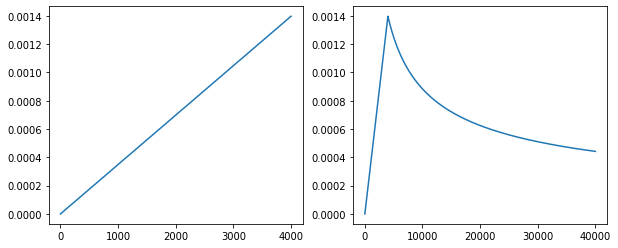

In [59]:
# testing customSchedule
temp_lr_schedule = CustomSchedule(dims)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(temp_lr_schedule(tf.range(4000, dtype=tf.float32)));
plt.subplot(122)
plt.plot(temp_lr_schedule(tf.range(40000, dtype=tf.float32)));

## Train Translator 🚆

In [60]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, dims, dense_units, num_heads, num_layers,
               input_vectorizer, output_vectorizer,
               drop_out_rate=0.1, MAX_TOKENS=16,
               use_tf_function=False):
    
    super(TrainTranslator, self).__init__()
    self.use_tf_function = use_tf_function
    self.input_vectorizer = input_vectorizer
    self.output_vectorizer = output_vectorizer

    self.transformer = Transformer(dims,
                                   dense_units,
                                   num_heads,
                                   num_layers,
                                   input_vectorizer.vocabulary_size(),
                                   output_vectorizer.vocabulary_size(),
                                   drop_out_rate,
                                   MAX_TOKENS)


  def train_step(self, inputs):
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)



### Accuracy Metrics 📐

In [61]:
def _accuracy_metric(self, y_true, y_pred):
  # [batch, seq, vocab] --> [batch, seq]
  y_pred = tf.argmax(y_pred, axis=-1)
  mask = tf.not_equal(y_true, 0)
  acc = tf.equal(y_true, y_pred)
  acc = tf.logical_and(acc, mask)

  acc = tf.cast(acc, dtype=y_true.dtype)
  mask = tf.cast(mask, dtype=y_true.dtype)
  
  accuracy = tf.reduce_sum(acc) / tf.reduce_sum(mask)
  return accuracy

TrainTranslator._accuracy_metric = _accuracy_metric

### train_step 🖥

In [62]:

def _train_step(self, inputs):
  #  tokens shape -- [batch, tokens]
  eng, mal = inputs
  
  # teacher forcing
  mal_x = mal[:, :-1]
  mal_y = mal[:, 1:]

  with tf.GradientTape() as tape:
    preds, _ = self.transformer((eng, mal_x), training=True)
    loss = self.loss(mal_y, preds)
  
  gradients = tape.gradient(loss, self.trainable_variables)
  self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

  accuracy = self._accuracy_metric(mal_y, preds)
  return {'batch_loss':loss, 'batch_accuracy':accuracy}

TrainTranslator._train_step = _train_step

### Test the training step 🩺
Build a TrainTranslator, and configure it for training using the Model.compile method:


In [63]:
translator =  TrainTranslator(dims, dense_units, num_heads, num_layers,
               english_text_vectorizer, malayalam_text_vectorizer,
               drop_out_rate=0.1, MAX_TOKENS=16,
               use_tf_function=False)

learning_rate = CustomSchedule(dims)

translator.compile(loss=MaskedLoss(), 
                   optimizer=tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9))

In [64]:
%%time

for i in tf.range(10):
  print(translator._train_step((sample_english_tokens, sample_malayalam_tokens)))

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.993919>, 'batch_accuracy': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=9.000819>, 'batch_accuracy': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.988542>, 'batch_accuracy': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.983981>, 'batch_accuracy': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.987099>, 'batch_accuracy': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.984719>, 'batch_accuracy': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.999385>, 'batch_accuracy': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float

### tf_train_step 🖥

In [65]:
@tf.function(input_signature=[[tf.TensorSpec(shape=[None, None], dtype=tf.int64),
                               tf.TensorSpec(shape=[None, None], dtype=tf.int64)]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

TrainTranslator._tf_train_step = _tf_train_step

In [66]:
%%time

translator =  TrainTranslator(dims, dense_units, num_heads, num_layers,
               english_text_vectorizer, malayalam_text_vectorizer,
               drop_out_rate=0.1, MAX_TOKENS=16,
               use_tf_function=True)

learning_rate = CustomSchedule(dims)

translator.compile(loss=MaskedLoss(), 
                   optimizer=tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9))

translator.train_step((sample_english_tokens, sample_malayalam_tokens))

CPU times: user 19.1 s, sys: 364 ms, total: 19.5 s
Wall time: 31 s


In [67]:
%%time

for i in tf.range(10):
  print(translator.train_step((sample_english_tokens, sample_malayalam_tokens)))

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.980841>, 'batch_accuracy': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.9774275>, 'batch_accuracy': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.985352>, 'batch_accuracy': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.979693>, 'batch_accuracy': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.98733>, 'batch_accuracy': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.985527>, 'batch_accuracy': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.978388>, 'batch_accuracy': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float

A good test of a new model is to see that it can overfit a single batch of input. Try it, the loss should quickly go to zero:

In [68]:
logs = {'loss':[], 'acc':[]}

for i in tf.range(50):
 log = translator.train_step((sample_english_tokens, sample_malayalam_tokens))
 logs['loss'].append(log['batch_loss'].numpy())
 logs['acc'].append(log['batch_accuracy'].numpy())


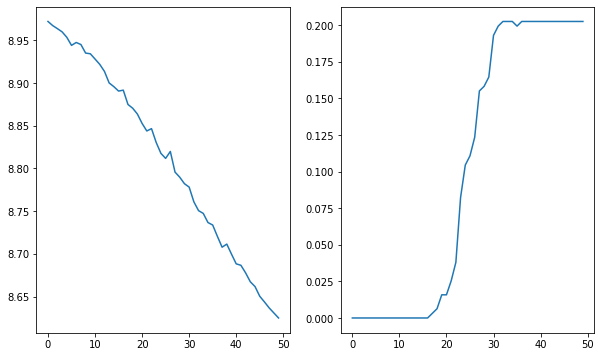

In [69]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot(logs['loss'])
plt.subplot(122)
plt.plot(logs['acc'])

Now that you're confident that the training step is working, build a fresh copy of the model to train from scratch:

## Logging batch loss 🔊

In [70]:

class Batch_loss(tf.keras.callbacks.Callback):
  def __init__(self, key_1, key_2):
    self.key_1 = key_1
    self.key_2 = key_2
    self.loss=[]
    self.acc=[]
  def on_train_batch_end(self, n, logs):
    self.loss.append(logs[self.key_1])
    self.acc.append(logs[self.key_2])

batch_logs =Batch_loss('batch_loss', 'batch_accuracy')

## Model Training 🎆

In [72]:
translator =  TrainTranslator(dims, dense_units, num_heads, num_layers,
               english_text_vectorizer, malayalam_text_vectorizer,
               drop_out_rate=0.1, MAX_TOKENS=16,
               use_tf_function=True)

learning_rate = CustomSchedule(dims)

translator.compile(loss=MaskedLoss(), 
                   optimizer=tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9),
                   metrics=['accuracy'])

translator.fit(token_ds, epochs=20, callbacks=[batch_logs])

Epoch 1/20
489/489 [==============================] - 57s 43ms/step - batch_loss: 7.3345 - batch_accuracy: 0.2016
Epoch 2/20
489/489 [==============================] - 21s 43ms/step - batch_loss: 5.0368 - batch_accuracy: 0.3249
Epoch 3/20
489/489 [==============================] - 24s 49ms/step - batch_loss: 4.0882 - batch_accuracy: 0.4268
Epoch 4/20
489/489 [==============================] - 20s 41ms/step - batch_loss: 3.4625 - batch_accuracy: 0.4812
Epoch 5/20
489/489 [==============================] - 21s 42ms/step - batch_loss: 2.9558 - batch_accuracy: 0.5354
Epoch 6/20
489/489 [==============================] - 20s 41ms/step - batch_loss: 2.5170 - batch_accuracy: 0.5940
Epoch 7/20
489/489 [==============================] - 21s 42ms/step - batch_loss: 2.2021 - batch_accuracy: 0.6341
Epoch 8/20
489/489 [==============================] - 21s 43ms/step - batch_loss: 2.0012 - batch_accuracy: 0.6574
Epoch 9/20
489/489 [==============================] - 21s 43ms/step - batch_loss: 1.8336

## Inference 💭

In [73]:
class Translation(tf.Module):

  def __init__(self, transformer, input_vectorizer, output_vectorizer):
    super(Translation, self).__init__()
    self.transformer = transformer
    self.input_vectorizer = input_vectorizer
    self.output_vectorizer = output_vectorizer

    self.tokens_to_strings = tf.keras.layers.StringLookup( mask_token="",
                                                          vocabulary=output_vectorizer.get_vocabulary(),
                                                          invert=True)
    
    strings_to_tokens = tf.keras.layers.StringLookup( mask_token="",
                                                          vocabulary=output_vectorizer.get_vocabulary())
    
    self.mask_tokens = tf.constant(['', '[UNK]', '[START]','[END]'])

    self.start = strings_to_tokens(tf.constant('[START]'))
    self.end = strings_to_tokens(tf.constant('[END]'))

  # clean-up utility output text from tokens
  def clean_text(self, tokens):
    word_tokens = self.tokens_to_strings(tokens)
    texts = tf.TensorArray(dtype=tf.string, size=0, dynamic_size=True)
    batch_size = tf.shape(word_tokens)[0]
    for i in tf.range(batch_size):
      words = word_tokens[i]
      clean = tf.constant([w.numpy() for w in words if w not in self.mask_tokens])
      clean = tf.strings.reduce_join(clean, separator=' ')
      texts = texts.write(i, clean)
    return texts.stack()


  def __call__(self, input_text , MAX_TOKENS=30):

    # get tokens -- [batch, tokens]
    input_tokens = self.input_vectorizer(input_text)

    batch_size = tf.shape(input_tokens)[0]
    
    # initialize output with start tokens
    output_tokens = tf.fill([batch_size, 1], self.start)

    # check for end of translation
    done = tf.zeros([batch_size,1], dtype=tf.bool)

    # tensor array to keep track of new predictions
    result_tokens = tf.TensorArray(dtype=tf.int64, size=1, dynamic_size=True)
    result_tokens = result_tokens.write(0, output_tokens)

    for i in tf.range(MAX_TOKENS):
      # [batch, seq, vocab]
      logits, _ = self.transformer((input_tokens, output_tokens), training=False)
      
      # take the last prediction [batch, seq, vocab] --> [batch, 1, vocab]
      logits = logits[:,-1:, :]

      # [batch, 1, vocab] --> [batch, 1]
      predictions = tf.argmax(logits, axis=-1) 

      done = done|(predictions == self.end)
      predictions = tf.where( done, tf.constant(0, dtype=tf.int64), predictions)

      # write the results
      result_tokens = result_tokens.write(i+1, predictions)

      #  concat the newly predicted to the right output-sequence
      temp = result_tokens.stack() # [i, batch, 1]
      #  [i, batch, 1] --> [i, batch]
      temp = tf.squeeze(temp, axis=-1)
      #  [i, batch] --> [batch, i]
      output_tokens = tf.transpose(temp)

      if tf.reduce_all(done):
        break

    # Prepare the results 
    result = result_tokens.stack() # [i, batch, 1]
    #  [i, batch, 1] --> [i, batch]
    result = tf.squeeze(result, axis=-1)
    #  [i, batch] --> [batch, i]
    result = tf.transpose(result)

    # Attention weights 
    _, attention_weights = self.transformer((input_tokens, result[:,:-1]), training=False)

    # ouput malayalam text -- after removing [UNK], [START] etc...
    texts = self.clean_text(result)

    output_dict = {
        'input_texts' : input_text,
        'input_tokens' : input_tokens,
        'output_tokens' : result,
        'attention_weights' : attention_weights,
        'output_texts' : texts
    }

    return output_dict


## Testing inference 🧪

In [74]:
translation = Translation(transformer = translator.transformer,
                          input_vectorizer = english_text_vectorizer,
                          output_vectorizer = malayalam_text_vectorizer)

In [155]:
# our training set consist of primarily short sentences so model perform good in short sentences
# The quality of the model depends on the quality of the data
# input query
sample = tf.constant([
    'Some red flowers',
    'The flowers are yellow',
    "Some people are walking",
    'Some cars are red',
    'Big building',
    'This is my car',
    'Name of the woman',
    'The elephant in the room',
    'my computer is here',
    'People are in the bus',
    'this is really good',
    'here is my the building',
    'this is cat',
    'he is young',
    'birds fly high',
    'i am working'])

result = translation(sample)

# pred
preds = result['output_texts']

for txt in preds:
  print((txt.numpy()).decode())

ചില ചുവന്ന പൂക്കൾ
പൂക്കൾ മഞ്ഞയാണ്
ചില ആളുകൾ നടക്കുന്നു
ചില കാറുകൾ ചുവപ്പാണ്
വലിയ കെട്ടിടം
ഇത് എന്റെ കാറാണ്
സ്ത്രീയുടെ പേര്
മുറിയിൽ ആന
എന്റെ കമ്പ്യൂട്ടർ ഇവിടെയുണ്ട്
ആളുകൾ ബസ്സിൽ
ഇത് നല്ല നല്ല നല്ല
ഇവിടെ എന്റെ കെട്ടിടമാണ്
ഇതാണ് പൂച്ച
അവൻ ചെറുപ്പമാണ്
പക്ഷികൾ ഉയരത്തിൽ പറക്കുന്നു
ഞാൻ ജോലി ചെയ്യുന്നു.


In [156]:
weights = result['attention_weights']
weights.keys()

dict_keys(['attention_weights_block_1-0', 'attention_weights_block_2-0', 'attention_weights_block_1-1', 'attention_weights_block_2-1', 'attention_weights_block_1-2', 'attention_weights_block_2-2', 'attention_weights_block_1-3', 'attention_weights_block_2-3'])

In [157]:
cross_attention = weights['attention_weights_block_2-3']
# we have tested 16 translation
cross_attention.shape
# shape -- [batch, head, query, key]
# here query = english
# and key = malayalam
# lets make some plots

TensorShape([16, 8, 6, 7])

In [158]:
id = 0
w = cross_attention[id]
w.shape

TensorShape([8, 6, 7])

In [160]:
# query
print([word.decode() for word in (sample.numpy()[id]).split()])
# keys
print([word for word in (preds.numpy()[id]).decode().split()])

['Some', 'red', 'flowers']
['ചില', 'ചുവന്ന', 'പൂക്കൾ']


['ചില', 'ചുവന്ന', 'പൂക്കൾ']


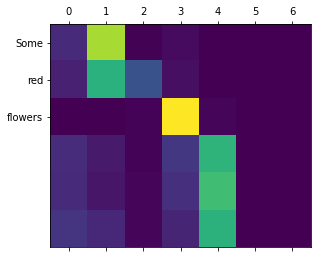

In [161]:
# there is some issue with malayalam fonts and matplotlib 
# so i am limiting this plot to just one attention head
# matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 3381 missing from current font.
# plt.xticks(ticks, keys)  -- this cause problems

for head in w:
  plt.matshow(head)
  q = [word.decode() for word in (sample.numpy()[id]).split()]
  plt.yticks(ticks=range(len(q)), labels=q)
  break

print([str(word )for word in preds.numpy()[id].decode().split()])

### Performance on data that is used in training 🏃

In [149]:
result = translation(sample_english_batch)

In [150]:
# query
eng = result['input_texts']
# true
mal = sample_malayalam_batch
# pred
preds = result['output_texts']

In [151]:
# By reviewing you can find that data quality is not great
# First of all -- we have only short sentences 
# We have mistake in translation

# for example
# English :
# a dog on a couch
# Prediction :
# കട്ടിലിൽ ഒരു നായ
# True labels used to train the model :
# ഒരു ബാഗ് കോട്ടൺ മിഠായി

# We can see that our model was able to generate correct prediction 
# even though the translation provided was wrong
# there are many such examples
# But give this data -- our model is performing good

# here is one more
# English :
# this is a cow
# Prediction :
# ഇതൊരു പശുവാണ്
# True labels used to train the model :
# ചാരനിറത്തിലുള്ള റോഡിന്റെ വശങ്ങളിൽ പച്ച പുല്ലിന്റെ സ്ട്രിപ്പുകൾ

for en, y_pred, y_true in zip(eng, preds, mal):
  print('English :')
  print((en.numpy()).decode())
  print('Prediction :')
  print((y_pred.numpy()).decode())  
  print('True labels used to train the model :')
  print((y_true.numpy()).decode())
  print('-'*70)

English :
the carton is gold
Prediction :
കാർട്ടൂൺ സ്വർണ്ണമാണ്
True labels used to train the model :
സ്വർണ നിറമുള്ള കാർഡ്ബോർഡ് പെട്ടി
----------------------------------------------------------------------
English :
glass window on building
Prediction :
വർണ്ണാഭമായ സ്കാർഫ് ധരിച്ച ഒരു സ്ത്രീ
True labels used to train the model :
വർണ്ണാഭമായ സ്കാർഫ് ധരിച്ച ഒരു സ്ത്രീ
----------------------------------------------------------------------
English :
large tan clay pot
Prediction :
വലിയ ടാൻ കളിമൺ കലം
True labels used to train the model :
വലിയ ടാൻ കളിമൺ കലം
----------------------------------------------------------------------
English :
the signs are neon
Prediction :
അടയാളങ്ങൾ നിയോൺ ആണ്
True labels used to train the model :
അടയാളങ്ങൾ നിയോൺ ആണ്
----------------------------------------------------------------------
English :
green peas
Prediction :
ഗ്രീൻ പീസ്
True labels used to train the model :
ഗ്രീൻ പീസ്
----------------------------------------------------------------------
English :
man weari